In [6]:
pip install faker meteostat requests

  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.2-cp312-cp312-win_amd64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.2-cp312-cp312-win_amd64.whl (105 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)

   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   -------- ------------------------------- 1/5 [idna]
   ---------------- ----------------------- 2/5 [charset_normalizer]
   -------------------------------- ------- 4/5 [requests]
   -------------------------------- ------- 4/5 [requests]
   ---------------------------------------- 5/5 [requests]

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Generation of fake data for policy and claims datasets

from faker import Faker
import pandas as pd
import random 
from datetime import datetime

#change the data to 5 crore max else everything wwill be very high
fake = Faker('en_US')

users = []
policies = []
claims = []

nri_data=pd.read_csv('NRI_Table_Counties.csv')
locations=nri_data['COUNTY']

for _ in range(6000): 
    user = {
        'user_id': fake.bothify('USER-####-????'),
        'name': fake.name(),
        'age': random.randint(18, 80),
    }
    users.append(user)
    valid_locations = nri_data[['COUNTY', 'STATE', 'COUNTYTYPE']].drop_duplicates().values.tolist()

    num_policies = random.randint(1, 5)
    for _ in range(num_policies):
        policy_id = fake.bothify('POL-####-????')
        policy_date=pd.to_datetime(fake.date_between_dates(date_start=datetime(1980, 1, 1), date_end=datetime.now()))
        prop_val=random.randint(100000,100000000)
        
        if(prop_val<500000):
            prop_type="low"
        elif(prop_val>=500000 and prop_val<=5000000):
            prop_type="medium"
        elif(prop_val>5000000 and prop_val<=15000000):
            prop_type="high"
        else:
            prop_type="very high"
        
        county, state, county_type = random.choice(valid_locations)
        policy = {
            'user_id': user['user_id'],
            'policy_id': policy_id,
            'policy_date':policy_date,
            'COUNTY':county,
            'STATE':state,
            'COUNTYTYPE':county_type,
            'property_value':prop_val,
            'property_type':prop_type
        }    

        policies.append(policy)

        num_claims = random.randint(1, 5)
        for _ in range(num_claims):
            claim_date = pd.to_datetime(fake.date_between_dates(date_start=policy_date, date_end=datetime.now()))
            duration = (claim_date - policy_date).days
            damage=round(random.uniform(0,1),2)
            claim = {
                'user_id': user['user_id'],
                'policy_id': policy_id,
                'claims_id': fake.uuid4(),
                'policy_date': policy_date,
                'claim_date': claim_date,
                'duration': duration,
                'damage':damage
            }
            claims.append(claim)

policy_df = pd.DataFrame(policies).merge(pd.DataFrame(users), on='user_id')
claims_df = pd.DataFrame(claims)
policy_df['policy_date'] = policy_df['policy_date'].dt.strftime('%Y-%m-%d')
claims_df['claim_date'] = claims_df['claim_date'].dt.strftime('%Y-%m-%d')

merged_df=pd.merge(policy_df,claims_df,on=['user_id','policy_id'],how='inner')
merged_df=merged_df.drop('policy_date_y',axis=1)
merged_df=merged_df.rename(columns={'policy_date_x':'policy_date'})

policy_df.to_csv('policy_Data.csv', index=False)
claims_df.to_csv('claims_Data.csv', index=False)
merged_df.to_csv('merged_data.csv',index=False)

# load the nri dataset and then randomly assign the users to a particular location , merge  plocu and claims id with FEMA dataset
final_df=pd.merge(merged_df,nri_data,on=['COUNTY','STATE','COUNTYTYPE'],how='outer')
final_df['policy_date'] = pd.to_datetime(final_df['policy_date'], errors='coerce').dt.strftime('%Y-%m-%d')
final_df['claim_date'] = pd.to_datetime(final_df['claim_date'], errors='coerce').dt.strftime('%Y-%m-%d')

final_df.to_csv('final_data.csv',index=False)


In [4]:

#adding property value, sum insured, damage costs and deductible for every row in final data


import pandas as pd
import numpy as np
import random

final_data = pd.read_csv('final_data.csv')

sum_insured_list = []
base_amount = 10000000
claim_amount_list=[]
deductabile_list=[]
damage_cost_list=[]

def calculate_deductible(risk, property_value):
    risk = risk.lower()
    if risk == "very high":
        return 0.1 * property_value 
    elif risk == "relatively high":
        return 0.07 * property_value
    elif risk == "relatively moderate":
        return 0.05 * property_value
    elif risk == "relatively low":
        return 0.03 * property_value
    elif risk == "very low":
        return 0.01 * property_value
    else:
        return 0.0

def get_sum_insured_multiplier(risk, prop):
    if not isinstance(risk, str) or not isinstance(prop, str):
        return 0.0
    risk = risk.lower()
    prop = prop.lower()

    ranges = {
        'very high': {
            'very high': (0.8, 1.0),
            'high': (0.7, 0.9),
            'medium': (0.6, 0.8),
            'low': (0.5, 0.7)
        },
        'relatively high': {
            'very high': (0.7, 0.9),
            'high': (0.6, 0.8),
            'medium': (0.5, 0.7),
            'low': (0.4, 0.6)
        },
        'relatively moderate': {
            'very high': (0.6, 0.8),
            'high': (0.5, 0.7),
            'medium': (0.3, 0.5),
            'low': (0.2, 0.4)
        },
        'relatively low': {
            'very high': (0.4, 0.6),
            'high': (0.3, 0.5),
            'medium': (0.2, 0.4),
            'low': (0.1, 0.3)
        },
        'very low': {
            'very high': (0.2, 0.4),
            'high': (0.1, 0.3),
            'medium': (0.05, 0.2),
            'low': (0.03, 0.1)
        }
    }

    try:
        min_val, max_val = ranges[risk][prop]
        return random.uniform(min_val, max_val)
    except KeyError:
        return 0.0  


for index, row in final_data.iterrows():
    risk = row['RISK_RATNG']
    prop_type = row['property_type']  
    prop_val=row['property_value']
    damage_per=row['damage']
    
    multiplier = get_sum_insured_multiplier(risk, prop_type)
    sum_insured_value = min(round(multiplier * base_amount, 2),prop_val*1.2)
    sum_insured_list.append(round(sum_insured_value,2))
    damage_cost=damage_per*prop_val
    damage_cost_list.append(round(damage_cost,2))
    deductabile=calculate_deductible(risk=risk,property_value=prop_val)
    deductabile_list.append(round(deductabile,2))
    claim_amount =max(min(damage_cost,sum_insured_value)-deductabile,0)
    claim_amount_list.append(round(claim_amount,2))
    
new_final=final_data
new_final['sum_insured'] = sum_insured_list
new_final['claim_amount']=claim_amount_list
new_final['deductabile']=deductabile_list
new_final['damage_cost']=damage_cost_list

#reposition
cols = list(new_final.columns)
for col in ['sum_insured', 'claim_amount', 'deductabile','damage_cost']:
    cols.remove(col)

cols[10:10] = ['sum_insured', 'claim_amount', 'deductabile','damage_cost']


new_final = new_final[cols]
new_final.to_csv('new_final.csv', index=False)


In [ ]:
#Weather data creation from NOAA data
import requests
import numpy as np
import pandas as pd
from meteostat import Point, Daily

# usecols=['BEGIN_YEARMONTH','BEGIN_DAY','END_YEARMONTH','END_DAY','STATE']
# dtypes = {
#     'BEGIN_YEARMONTH.': str,
#     'BEGIN_DAY': str,
#     'END_YEARMONTH': str,
#     'END_DAY': str,
#     'STATE': str,
# }

# df_2000=pd.read_csv('2000.csv',usecols=usecols,dtype=dtypes)
# df_2001=pd.read_csv('2001.csv',usecols=usecols,dtype=dtypes)
# df_2002=pd.read_csv('2002.csv',usecols=usecols,dtype=dtypes)
# df_2003=pd.read_csv('2003.csv',usecols=usecols,dtype=dtypes)
# df_2004=pd.read_csv('2004.csv',usecols=usecols,dtype=dtypes)
# df_2005=pd.read_csv('2005.csv',usecols=usecols,dtype=dtypes)
# df_2006=pd.read_csv('2006.csv',usecols=usecols,dtype=dtypes)
# df_2007=pd.read_csv('2007.csv',usecols=usecols,dtype=dtypes)
# df_2008=pd.read_csv('2008.csv',usecols=usecols,dtype=dtypes)
# df_2009=pd.read_csv('2009.csv',usecols=usecols,dtype=dtypes)
# df_2010=pd.read_csv('2010.csv',usecols=usecols,dtype=dtypes)

# df_2011=pd.read_csv('2011.csv',usecols=usecols,dtype=dtypes)
# df_2012=pd.read_csv('2012.csv',usecols=usecols,dtype=dtypes)
# df_2013=pd.read_csv('2013.csv',usecols=usecols,dtype=dtypes)
# df_2014=pd.read_csv('2014.csv',usecols=usecols,dtype=dtypes)
# df_2015=pd.read_csv('2015.csv',usecols=usecols,dtype=dtypes)
# df_2016=pd.read_csv('2016.csv',usecols=usecols,dtype=dtypes)
# df_2017=pd.read_csv('2017.csv',usecols=usecols,dtype=dtypes)
# df_2018=pd.read_csv('2018.csv',usecols=usecols,dtype=dtypes)
# df_2019=pd.read_csv('2019.csv',usecols=usecols,dtype=dtypes)


# df_2021=pd.read_csv('2021.csv',usecols=usecols,dtype=dtypes)
# df_2022=pd.read_csv('2022.csv',usecols=usecols,dtype=dtypes)
# df_2023=pd.read_csv('2023.csv',usecols=usecols,dtype=dtypes)
# df_2024=pd.read_csv('2024.csv',usecols=usecols,dtype=dtypes)


# combined = pd.concat([df_2001, df_2002,df_2003,df_2004,df_2005,df_2006,df_2007,df_2008,df_2009,df_2010,df_2011, df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018,df_2019,df_2021,df_2022,df_2023,df_2024], ignore_index=True)
# combined.to_csv('combined_weather.csv',index=False)

# weather=pd.read_csv('fin_weather.csv')
# weather=weather.drop_duplicates()

# weather.to_csv('weather.csv',index=False)

weather=pd.read_csv('noa_final.csv')

state_geocodes = {
    "Alabama": (32.3777, -86.3000),
    "Alaska":(61.2181, -149.9003),
    "Arizona": (33.4484, -112.0740),
    "Arkansas": (34.969704, -92.373123),
    "California": (36.116203, -119.681564),
    "Colorado": (39.059811, -105.311104),
    "Connecticut": (41.597782, -72.755371),
    "Delaware": (39.318523, -75.507141),
    "Florida": (27.766279, -81.686783),
    "Georgia":(33.7490, -84.3880),
    "Hawaii": (21.094318, -157.498337),
    "Idaho": (43.6150, -116.2023),
    "Illinois": (40.349457, -88.986137),
    "Indiana": (39.849426, -86.258278),
    "Iowa": (42.011539, -93.210526),
    "Kansas":(39.0119, -98.4842),
    "Kentucky": (37.668140, -84.670067),
    "Louisiana":(30.6954, -91.1856),
    "Maine": (44.693947, -69.381927),
    "Maryland": (39.063946, -76.802101),
    "Massachusetts": (42.230171, -71.530106),
    "Michigan": (43.326618, -84.536095),
    "Minnesota": (45.694454, -93.900192),
    "Mississippi": (32.2988, -90.1848),
    "Missouri": (38.456085, -92.288368),
    "Montana": (46.921925, -110.454353),
    "Nebraska": (41.125370, -98.268082),
    "Nevada": (38.313515, -117.055374),
    "New Hampshire": (43.452492, -71.563896),
    "New Jersey": (40.298904, -74.521011),
    "New Mexico": (34.840515, -106.248482),
    "New York": (42.165726, -74.948051),
    "North Carolina": (35.630066, -79.806419),
    "North Dakota": (47.528912, -99.784012),
    "Ohio": (40.388783, -82.764915),
    "Oklahoma": (35.565342, -96.928917),
    "Oregon": (44.9429, -123.0351),
    "Pennsylvania": (40.2732, -76.8867),
    "Rhode Island": (41.680893, -71.511780),
    "South Carolina": (33.856892, -80.945007),
    "South Dakota": (44.3683, -100.3510),
    "Tennessee": (35.747845, -86.692345),
    "Texas": (31.054487, -97.563461),
    "Utah": (40.150032, -111.862434),
    "Vermont": (44.045876, -72.710686),
    "Virginia": (37.769337, -78.169968),
    "Washington": (47.400902, -121.490494),
    "West Virginia": (38.491226, -80.954570),
    "Wisconsin": (44.268543, -89.616508),
    "Wyoming": (41.1403, -104.8202),
    "Puerto Rico": (18.4655, -66.1057),
    "Virgin Islands": (18.3419, -64.9307),
    "Northern Mariana Islands": (15.1778, 145.7500)
}

records = []
for index, row in weather.iloc[:169500].iterrows():

    start = row['BEGIN_DATE']
    end = row['END_DATE']
    location = row['STATE']
    
    if isinstance(location, str):
        location = location.strip().title()
        print(f"[{index}] Processing location: {location}")
    else:
        print(f"[{index}] Skipped: STATE is not a string (value: {location})")
        continue

    if location not in state_geocodes:
        print(f"[{index}] Skipped: '{location}' not in geocode dictionary")
        continue

    lat, lon = state_geocodes[location]
    place = Point(lat, lon)

    try:
     
        start_dt = pd.to_datetime(start)
        end_dt = pd.to_datetime(end)
        window_start = start_dt - pd.Timedelta(days=6)
        window_end = start_dt + pd.Timedelta(days=1)

        if start_dt > end_dt:
            print(f"[{index}] Skipped: Start date {start_dt} > End date {end_dt}")
            continue

        print(f"[{index}] Fetching weather for {location} from {start_dt.date()} to {end_dt.date()}")

        data = Daily(place, start=window_start, end=window_end).fetch()

        for date, row_weather in data.iterrows():
            records.append({
                "State": location,
                "Begin_date": start_dt,
                "End_date": end_dt,
                "Date": date,
                "Latitude": lat,
                "Longitude": lon,
                "Tavg": row_weather.get("tavg", None),
                "Tmin": row_weather.get("tmin", None),
                "Tmax": row_weather.get("tmax", None),
                "Precipitation": row_weather.get("prcp", None),
                "Snowfall": row_weather.get("snow", None),
                "WindSpeed": row_weather.get("wspd", None)
            })

        print(f"[{index}] ✓ Weather data fetched: {len(data)} rows")

    except Exception as e:
        print(f"[{index}]  Failed for {location} ({start} to {end}): {e}")
        continue

weather_df = pd.DataFrame(records)
print("\nWeather data collection completed.")
print(weather_df.head())
weather_df.to_csv('weather_Data.csv', index=False)
print(" Data saved to weather_Data.csv")



weather_Data=pd.read_csv('weather_Data.csv')

grouped = weather_Data.groupby(['State', 'Begin_date', 'End_date']).agg({
    'Tavg': 'mean',
    'Tmin': 'min',
    'Tmax': 'max',
    'Precipitation': 'sum',
    'Snowfall': 'sum',
    'WindSpeed': 'mean'
}).reset_index()

#final weather data with weather data for every disaster in every state 
grouped.to_csv('final_weather.csv',index=False)

[0] Processing location: Texas
[0] Fetching weather for Texas from 2001-11-28 to 2001-11-29


In [1]:
#merge final weather data and merged claims,policy and FEMA data
#merge weather data with final data
#remove policy date, age and claim date from final data

import pandas as pd
import numpy as np

weather_df = pd.read_csv("final_weather.csv", parse_dates=["Begin_date", "End_date"])
final_df = pd.read_csv("new_final.csv")

final_df = final_df.drop('policy_date',axis=1)
final_df = final_df.drop('age',axis=1)
final_df = final_df.drop('name',axis=1)
final_df = final_df.drop('duration',axis=1)
final_df = final_df.drop('claim_date',axis=1)


weather_df.rename(columns={"State": "STATE"}, inplace=True)

def assign_weather_by_state(policy_row):
    state = policy_row["STATE"]
    candidates = weather_df[weather_df["STATE"] == state]
    
    if candidates.empty:
        return pd.Series([np.nan] * len(weather_df.columns), index=weather_df.columns)
    
    sampled_row = candidates.sample(1).iloc[0]
    return pd.Series(sampled_row)

sampled_weather = final_df.apply(assign_weather_by_state, axis=1)

merged = pd.concat([final_df.reset_index(drop=True), sampled_weather.reset_index(drop=True)], axis=1)
merged.to_csv("grand_final_data.csv", index=False)

In [2]:
#find claim date from begin and end date

import numpy as np
import pandas as pd
from datetime import datetime 

final_data=pd.read_csv('grand_final_data.csv')
claims_date=[]
claims_date_list=[]

for index,row in final_data.iterrows():
    start=pd.to_datetime(row['Begin_date'])
    end=pd.to_datetime(row['End_date'])
    
    if pd.isna(start) or pd.isna(end):
        claim_date = pd.NaT  
    elif(start==end):
        claim_date=start
    else:
        claim_date = start + pd.to_timedelta(np.random.randint(0, (end - start).days + 1), unit="D")

    claims_date_list.append(claim_date)

final_data['claims_date']=claims_date_list
final_data=final_data.drop('Begin_date',axis=1)
final_data=final_data.drop('End_date',axis=1)
final_data_cleaned = final_data.loc[:, ~final_data.columns.duplicated()]


final_data_cleaned.to_csv('removed_dates.csv',index=False)


In [3]:
#re-write 7 days weather avg -> left to do
#drop extra state column
#convert claims data -> claims year, claims month, claims day

import pandas as pd
import numpy as np

data=pd.read_csv('removed_dates.csv')

data.drop('STATE.1',axis=1,inplace=True)
month=[]
day=[]
year=[]
for index,row in data.iterrows():
    claims_date=row['claims_date']
    day.append(pd.to_datetime(claims_date).day)
    month.append(pd.to_datetime(claims_date).month)
    year.append(pd.to_datetime(claims_date).year)

    
data=data.drop('claims_date',axis=1)

data['claims_year']=year
data['claims_month']=month
data['claims_day']=day

cols_to_move = ['Tavg', 'Tmin', 'Tmax', 'Precipitation', 'Snowfall', 'WindSpeed', 
                 'claims_year', 'claims_month', 'claims_day']

remaining_cols = [col for col in data.columns if col not in cols_to_move]
final_cols = remaining_cols[:5] + cols_to_move + remaining_cols[5:]

data = data[final_cols]
data.to_csv('revised.csv',index=False)

In [4]:
#calculate the final target variable -> final_risk_score
import pandas as pd
import numpy as np

df = pd.read_csv('revised.csv')

print(df.shape)
print(df.columns)
print(df.head())

critical_cols = ['damage_cost', 'sum_insured', 'Tavg', 'Precipitation']
df.dropna(subset=critical_cols, inplace=True)

num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# data cleaning
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna('unknown')
hazard_eal_cols = [col for col in df.columns if 'EAL' in col and col.endswith(('P','B','T'))]
df['hazard_exposure_score'] = df[hazard_eal_cols].mean(axis=1)
def calc_weather_score(row):
    score = 0
    if row['Tmax'] > 38: score += 0.3  
    if row['Precipitation'] > 100: score += 0.3  
    if row['Snowfall'] > 20: score += 0.2  
    if row['WindSpeed'] > 50: score += 0.2  
    return min(score, 1.0)

df['weather_score'] = df.apply(calc_weather_score, axis=1)
df['sum_insured'] = df['sum_insured'].replace(0, np.nan)
df['sum_insured'].fillna(df['sum_insured'].median(), inplace=True)

df['raw_risk_score'] = df['damage_cost'] / df['sum_insured']
df['raw_risk_score'] = df['raw_risk_score'].clip(0, 1)
a = 0.4   # raw weather score
b = 0.3   # hazard score
mu = 0.3   #weather score

df['final_risk_score'] = (
    a * df['raw_risk_score'] +
    b * df['hazard_exposure_score'].fillna(0).clip(0, 1) +
    mu * df['weather_score']
).clip(0, 1)

# add noise
df['final_risk_score'] += np.random.normal(0, 0.01, size=len(df))
df['final_risk_score'] = df['final_risk_score']

df.to_csv('weather_risk.csv',index=False)

(53957, 484)
Index(['user_id', 'policy_id', 'COUNTY', 'STATE', 'COUNTYTYPE', 'Tavg', 'Tmin',
       'Tmax', 'Precipitation', 'Snowfall',
       ...
       'WNTW_EALS', 'WNTW_EALR', 'WNTW_ALRB', 'WNTW_ALRP', 'WNTW_ALRA',
       'WNTW_ALR_NPCTL', 'WNTW_RISKV', 'WNTW_RISKS', 'WNTW_RISKR', 'NRI_VER'],
      dtype='object', length=484)
          user_id      policy_id     COUNTY           STATE COUNTYTYPE  \
0  USER-6924-UlEp  POL-9296-zHRW  Abbeville  South Carolina     County   
1  USER-6924-UlEp  POL-9296-zHRW  Abbeville  South Carolina     County   
2  USER-6924-UlEp  POL-9296-zHRW  Abbeville  South Carolina     County   
3  USER-6897-OCJD  POL-2744-GGsz  Abbeville  South Carolina     County   
4  USER-6897-OCJD  POL-2744-GGsz  Abbeville  South Carolina     County   

      Tavg  Tmin  Tmax  Precipitation  Snowfall  ...  WNTW_EALS  WNTW_EALR  \
0  28.7750  22.0  38.9           52.8       0.0  ...   5.818632   Very Low   
1  27.7875  20.6  35.6           44.9       0.0  ...   5.818632   

C:\Users\csniv\AppData\Local\Temp\ipykernel_31444\1759722877.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hazard_exposure_score'] = df[hazard_eal_cols].mean(axis=1)
C:\Users\csniv\AppData\Local\Temp\ipykernel_31444\1759722877.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weather_score'] = df.apply(calc_weather_score, axis=1)
C:\Users\csniv\AppData\Local\Temp\ipykernel_31444\1759722877.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an in

 Data loaded successfully
 Shape: (53497, 488)

 Columns:
['user_id', 'policy_id', 'COUNTY', 'STATE', 'COUNTYTYPE', 'Tavg', 'Tmin', 'Tmax', 'Precipitation', 'Snowfall', 'WindSpeed', 'claims_year', 'claims_month', 'claims_day', 'property_value', 'property_type', 'sum_insured', 'claim_amount', 'deductabile', 'damage_cost', 'claims_id', 'damage', 'OID_', 'NRI_ID', 'STATEABBRV', 'STATEFIPS', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION', 'BUILDVALUE', 'AGRIVALUE', 'AREA', 'RISK_VALUE', 'RISK_SCORE', 'RISK_RATNG', 'RISK_SPCTL', 'EAL_SCORE', 'EAL_RATNG', 'EAL_SPCTL', 'EAL_VALT', 'EAL_VALB', 'EAL_VALP', 'EAL_VALPE', 'EAL_VALA', 'ALR_VALB', 'ALR_VALP', 'ALR_VALA', 'ALR_NPCTL', 'ALR_VRA_NPCTL', 'SOVI_SCORE', 'SOVI_RATNG', 'SOVI_SPCTL', 'RESL_SCORE', 'RESL_RATNG', 'RESL_SPCTL', 'RESL_VALUE', 'CRF_VALUE', 'AVLN_EVNTS', 'AVLN_AFREQ', 'AVLN_EXP_AREA', 'AVLN_EXPB', 'AVLN_EXPP', 'AVLN_EXPPE', 'AVLN_EXPT', 'AVLN_HLRB', 'AVLN_HLRP', 'AVLN_HLRR', 'AVLN_EALB', 'AVLN_EALP', 'AVLN_EALPE', 'AVLN_EALT', 'AVLN_EALS'

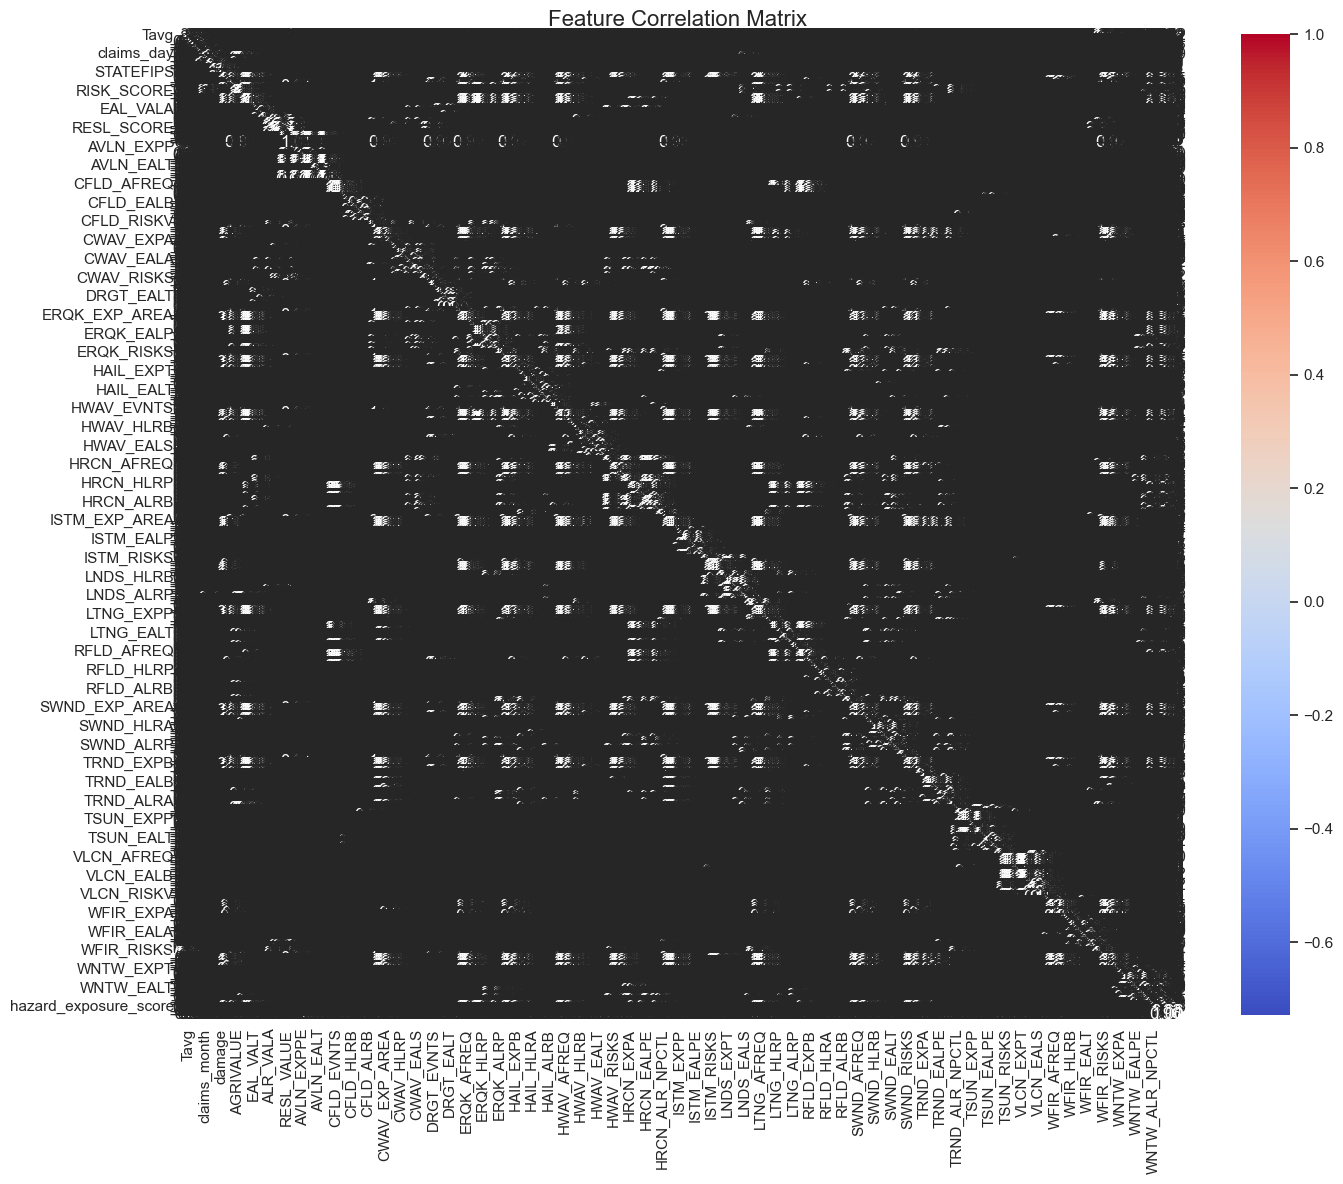

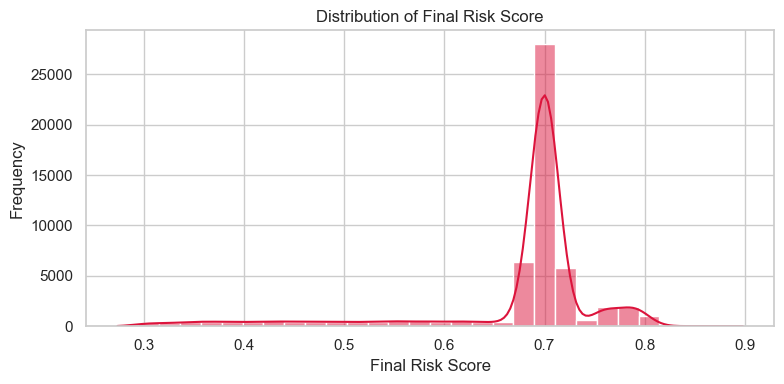

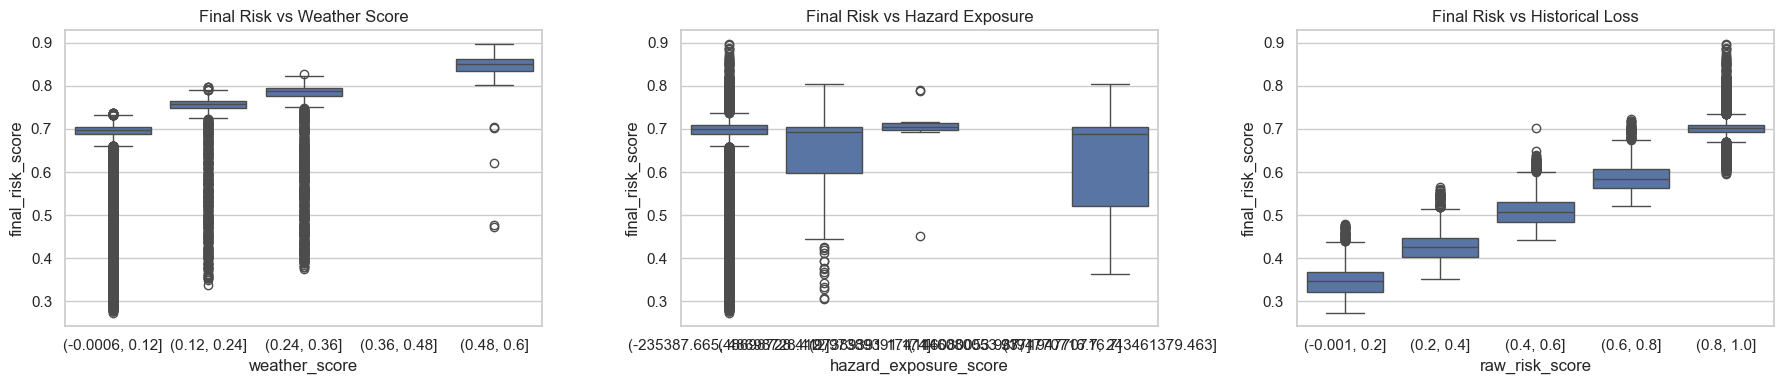

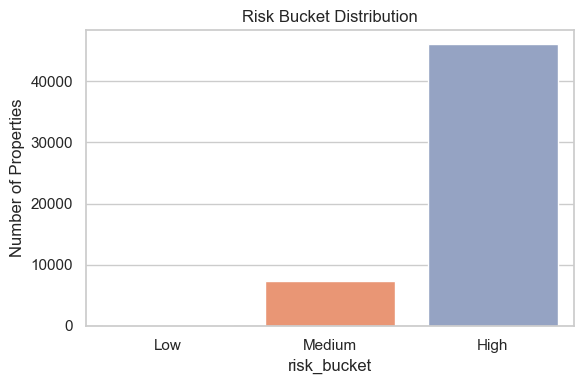

In [5]:
#EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

df = pd.read_csv("weather_risk.csv")
print(" Data loaded successfully")
print(" Shape:", df.shape)

print("\n Columns:")
print(df.columns.tolist())

print("\n Data Types:")
print(df.dtypes)

print("\n First 5 Rows:")
print(df.head())

missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Missing (%)': missing_percent})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values(by='Missing (%)', ascending=False)

print("\n Missing Values:")
print(missing_df)

num_cols = df.select_dtypes(include=np.number).columns.tolist()
print("\nDescriptive Statistics:")
print(df[num_cols].describe().T)

corr = df[num_cols].corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['final_risk_score'], bins=30, kde=True, color='crimson')
plt.title("Distribution of Final Risk Score")
plt.xlabel("Final Risk Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

sns.boxplot(data=df, y='final_risk_score', x=pd.cut(df['weather_score'], bins=5), ax=axs[0])
axs[0].set_title("Final Risk vs Weather Score")

sns.boxplot(data=df, y='final_risk_score', x=pd.cut(df['hazard_exposure_score'], bins=5), ax=axs[1])
axs[1].set_title("Final Risk vs Hazard Exposure")

sns.boxplot(data=df, y='final_risk_score', x=pd.cut(df['raw_risk_score'], bins=5), ax=axs[2])
axs[2].set_title("Final Risk vs Historical Loss")

plt.tight_layout()
plt.show()

def bucket(score):
    if score < 0.3:
        return "Low"
    elif score < 0.65:
        return "Medium"
    else:
        return "High"

df['risk_bucket'] = df['final_risk_score'].apply(bucket)

plt.figure(figsize=(6,4))
sns.countplot(x='risk_bucket', data=df, palette='Set2', order=["Low", "Medium", "High"])
plt.title("Risk Bucket Distribution")
plt.ylabel("Number of Properties")
plt.tight_layout()
plt.show()



In [7]:
#code to verify class balace and remove categorical data
#preprocessing and scaling
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE, ADASYN

def assign_risk_bucket(score):
    if 0 <= score <= 0.3:
        return 'low'
    elif 0.3 < score <= 0.7:
        return 'medium'
    else:
        return 'high'

# synthetic scores for upsampling
def generate_realistic_synthetic_scores(original_df, bucket, n_samples, random_state=42):
    np.random.seed(random_state)
    bucket_scores = original_df[original_df['Risk_Bucket'] == bucket]['final_risk_score'].values

    if len(bucket_scores) == 0:
        if bucket == 'low':
            return np.random.uniform(0.0, 0.3, n_samples)
        elif bucket == 'medium':
            return np.random.uniform(0.3, 0.7, n_samples)
        else:
            return np.random.uniform(0.7, 1.0, n_samples)

    mean_score = np.mean(bucket_scores)
    std_score = np.std(bucket_scores)
    synthetic_scores = np.random.normal(mean_score, std_score * 0.5, n_samples)

    if bucket == 'low':
        return np.clip(synthetic_scores, 0.0, 0.3)
    elif bucket == 'medium':
        return np.clip(synthetic_scores, 0.3, 0.7)
    else:
        return np.clip(synthetic_scores, 0.7, 1.0)

df = pd.read_csv("weather_risk.csv")
df['Risk_Bucket'] = df['final_risk_score'].apply(assign_risk_bucket)

# drop location based data and categorical data
geo_patterns = [
    "user_id", "policy_id", "COUNTY", "STATE", "COUNTYTYPE", "property_type", "claims_id",
    "NRI_ID", "STATEABBRV", "RISK_RATNG", "EAL_RATNG", "SOVI_RATNG", "RESL_RATNG",
    "AVLN_HLRR", "AVLN_EALR", "AVLN_RISKR", "CFLD_HLRR", "CFLD_EALR", "CFLD_RISKR",
    "CWAV_HLRR", "CWAV_EALR", "CWAV_RISKR", "DRGT_HLRR", "DRGT_EALR", "DRGT_RISKR",
    "ERQK_HLRR", "ERQK_EALR", "ERQK_RISKR", "HAIL_HLRR", "HAIL_EALR", "HAIL_RISKR",
    "HWAV_HLRR", "HWAV_EALR", "HWAV_RISKR", "HRCN_HLRR", "HRCN_EALR", "HRCN_RISKR",
    "ISTM_HLRR", "ISTM_EALR", "ISTM_RISKR", "LNDS_HLRR", "LNDS_EALR", "LNDS_RISKR",
    "LTNG_HLRR", "LTNG_EALR", "LTNG_RISKR", "RFLD_HLRR", "RFLD_EALR", "RFLD_RISKR",
    "SWND_HLRR", "SWND_EALR", "SWND_RISKR", "TRND_HLRR", "TRND_EALR", "TRND_RISKR",
    "TSUN_HLRR", "TSUN_EALR", "TSUN_RISKR", "VLCN_HLRR", "VLCN_EALR", "VLCN_RISKR",
    "WFIR_HLRR", "WFIR_EALR", "WFIR_RISKR", "WNTW_HLRR", "WNTW_EALR", "WNTW_RISKR",
    "NRI_VER"
]

drop_geo_cols = [col for col in df.columns if any(pat.lower() in col.lower() for pat in geo_patterns)]

if drop_geo_cols:
    print(f"Dropping geographic features: {drop_geo_cols}")
    df.drop(columns=drop_geo_cols, inplace=True)

X = df.drop(columns=['final_risk_score', 'Risk_Bucket']).dropna(axis=1, how='all')  
y_score = df['final_risk_score']
y_bucket = df['Risk_Bucket']

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

#preprocess
X_processed = preprocessor.fit_transform(X)  # Sparse matrix

#dimensionality reduction using truncated svd
print("Reducing dimensionality with TruncatedSVD...")
svd = TruncatedSVD(n_components=300, random_state=42)
X_reduced = svd.fit_transform(X_processed) 

#class balancing
original_counts = Counter(y_bucket)
max_count = max(original_counts.values())
imbalance_ratio = max_count / min(original_counts.values())

print(f"Original class distribution: {original_counts}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

try:
    if imbalance_ratio > 50:
        print("Severe imbalance — using SMOTE.")
        smote_strategy = {cls: max_count for cls in original_counts}
        X_resampled, y_bucket_resampled = SMOTE(sampling_strategy=smote_strategy, random_state=42).fit_resample(X_reduced, y_bucket)

    elif imbalance_ratio > 20:
        print("High imbalance — using SMOTE then ADASYN.")
        intermediate_target = int(max_count * 0.5)
        smote_strategy = {cls: max(count, intermediate_target) for cls, count in original_counts.items()}
        X_intermediate, y_intermediate = SMOTE(sampling_strategy=smote_strategy, random_state=42).fit_resample(X_reduced, y_bucket)

        adasyn_strategy = {cls: max_count for cls in Counter(y_intermediate)}
        X_resampled, y_bucket_resampled = ADASYN(sampling_strategy=adasyn_strategy, random_state=42).fit_resample(X_intermediate, y_intermediate)

    elif imbalance_ratio > 5:
        print("Moderate imbalance — using ADASYN.")
        adasyn_strategy = {cls: max_count for cls in original_counts}
        X_resampled, y_bucket_resampled = ADASYN(sampling_strategy=adasyn_strategy, random_state=42).fit_resample(X_reduced, y_bucket)

    else:
        print("Mild imbalance — using default ADASYN.")
        adasyn_strategy = {cls: max_count for cls in original_counts}
        X_resampled, y_bucket_resampled = ADASYN(sampling_strategy=adasyn_strategy, random_state=42).fit_resample(X_reduced, y_bucket)

except Exception as e:
    print(f"Resampling failed: {e}")
    exit()

print("Generating synthetic final_risk_score values...")
original_scores = y_score.tolist()
score_idx = 0
all_scores = []

for bucket in y_bucket_resampled:
    if score_idx < len(original_scores):
        all_scores.append(original_scores[score_idx])
        score_idx += 1
    else:
        all_scores.append(generate_realistic_synthetic_scores(df, bucket, 1)[0])

df_balanced = pd.DataFrame(X_resampled, columns=[f'PC{i+1}' for i in range(X_resampled.shape[1])])
df_balanced['final_risk_score'] = all_scores
df_balanced['Risk_Bucket'] = y_bucket_resampled

df_balanced.to_csv("balanced_weather_risk_dataset_no_geo.csv", index=False)
print("Balanced dataset saved as 'balanced_weather_risk_dataset_no_geo.csv'")
print(f"Final class distribution: {Counter(df_balanced['Risk_Bucket'])}")


Dropping geographic features: ['user_id', 'policy_id', 'COUNTY', 'STATE', 'COUNTYTYPE', 'property_type', 'claims_id', 'NRI_ID', 'STATEABBRV', 'STATEFIPS', 'COUNTYFIPS', 'RISK_RATNG', 'EAL_RATNG', 'SOVI_RATNG', 'RESL_RATNG', 'AVLN_HLRR', 'AVLN_EALR', 'AVLN_RISKR', 'CFLD_HLRR', 'CFLD_EALR', 'CFLD_RISKR', 'CWAV_HLRR', 'CWAV_EALR', 'CWAV_RISKR', 'DRGT_HLRR', 'DRGT_EALR', 'DRGT_RISKR', 'ERQK_HLRR', 'ERQK_EALR', 'ERQK_RISKR', 'HAIL_HLRR', 'HAIL_EALR', 'HAIL_RISKR', 'HWAV_HLRR', 'HWAV_EALR', 'HWAV_RISKR', 'HRCN_HLRR', 'HRCN_EALR', 'HRCN_RISKR', 'ISTM_HLRR', 'ISTM_EALR', 'ISTM_RISKR', 'LNDS_HLRR', 'LNDS_EALR', 'LNDS_RISKR', 'LTNG_HLRR', 'LTNG_EALR', 'LTNG_RISKR', 'RFLD_HLRR', 'RFLD_EALR', 'RFLD_RISKR', 'SWND_HLRR', 'SWND_EALR', 'SWND_RISKR', 'TRND_HLRR', 'TRND_EALR', 'TRND_RISKR', 'TSUN_HLRR', 'TSUN_EALR', 'TSUN_RISKR', 'VLCN_HLRR', 'VLCN_EALR', 'VLCN_RISKR', 'WFIR_HLRR', 'WFIR_EALR', 'WFIR_RISKR', 'WNTW_HLRR', 'WNTW_EALR', 'WNTW_RISKR', 'NRI_VER']
Reducing dimensionality with TruncatedSVD...


In [9]:
#XGBOOOST + checking for overfiting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor, plot_importance
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_model(y_true, y_pred, name="Test"):
    abs_errors = np.abs(y_true - y_pred)
    y_safe = y_true.copy()
    y_safe[y_safe == 0] = 1e-6  # prevent divide-by-zero
    
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'Acc ≤ 0.05': np.mean(abs_errors <= 0.05) * 100,
        'Acc ≤ 0.1': np.mean(abs_errors <= 0.1) * 100,
        'Acc ≤ 0.2': np.mean(abs_errors <= 0.2) * 100,
        'Rel ≤ 5%': np.mean(abs_errors / y_safe <= 0.05) * 100,
        'Rel ≤ 10%': np.mean(abs_errors / y_safe <= 0.1) * 100,
        'Rel ≤ 20%': np.mean(abs_errors / y_safe <= 0.2) * 100
    }
    
    print(f"\n=== XGBoost Regression Performance ({name} Set) ===")
    for k, v in metrics.items():
        print(f"{k:>15}: {v:.4f}")
    
    return metrics

df = pd.read_csv("balanced_weather_risk_dataset_no_geo.csv")
y = df["final_risk_score"]
X = df.drop(columns=["final_risk_score", "Risk_Bucket"], errors='ignore')


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

best_score = -np.inf
best_iteration = 0
patience = 20
no_improvement = 0


eval_history = {'train': [], 'test': []}

for n_estimators in [100, 200, 300, 400, 500]:
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        learning_rate=0.02,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.001,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
   
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    eval_history['train'].append(train_r2)
    eval_history['test'].append(test_r2)
    
    print(f"n_estimators: {n_estimators} | Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    
    if test_r2 > best_score:
        best_score = test_r2
        best_iteration = n_estimators
        best_model = model
        no_improvement = 0
    else:
        no_improvement += 1
        
    if no_improvement >= patience:
        print(f"Early stopping at {n_estimators} estimators")
        break

print("\nEvaluating for potential overfitting...")
train_metrics = evaluate_model(y_train, best_model.predict(X_train), "Train")
test_metrics = evaluate_model(y_test, best_model.predict(X_test), "Test")

plt.figure(figsize=(10, 6))
plt.plot([100, 200, 300, 400, 500][:len(eval_history['train'])], eval_history['train'], 'o-', label='Train R²')
plt.plot([100, 200, 300, 400, 500][:len(eval_history['test'])], eval_history['test'], 'o-', label='Test R²')
plt.axvline(x=best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('Performance vs Training Iterations')
plt.legend()
plt.grid()
plt.savefig('training_iterations.png')
plt.close()

r2_gap = train_metrics['R²'] - test_metrics['R²']
print(f"\nTrain-Test R² Gap: {r2_gap:.4f}")
if r2_gap > 0.1:
    print("Warning: Large gap suggests potential overfitting!")

print("\nPlotting learning curves...")
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train R²')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='CV R²')
plt.xlabel('Training Samples')
plt.ylabel('R² Score')
plt.title('Learning Curves')
plt.legend()
plt.grid()
plt.savefig('learning_curves.png')
plt.close()
print("saved to learning_curves.png")

# feature importance
print("\nAnalyzing feature importance...")
plt.figure(figsize=(12, 8))
plot_importance(best_model, max_num_features=20)
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()
print("saved to feature_importance.png")

# residual analysis
print("\nAnalyzing residuals...")
residuals = y_test - best_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(best_model.predict(X_test), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid()
plt.savefig('residuals.png')
plt.close()
print("saved to residuals.png")

# cross-validation
print("\nPerforming 5-Fold Cross-Validation on full data...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')

print(f"\nCV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Std CV R² : {cv_scores.std():.4f}")

joblib.dump(best_model, "xgb_risk_model.pkl")
print("\nModel saved to 'xgb_risk_model.pkl'")

if (test_metrics['R²'] > 0.9 and 
    r2_gap < 0.05 and 
    cv_scores.std() < 0.01):
    print("\nModel shows no signs of overfitting!")
else:
    print("\n Model may need regularization adjustments!")

n_estimators: 100 | Train R²: 0.9555 | Test R²: 0.9525
n_estimators: 200 | Train R²: 0.9823 | Test R²: 0.9793
n_estimators: 300 | Train R²: 0.9842 | Test R²: 0.9812
n_estimators: 400 | Train R²: 0.9845 | Test R²: 0.9816
n_estimators: 500 | Train R²: 0.9846 | Test R²: 0.9816

Evaluating for potential overfitting...

=== XGBoost Regression Performance (Train Set) ===
             R²: 0.9846
           RMSE: 0.0243
            MAE: 0.0141
     Acc ≤ 0.05: 94.3058
      Acc ≤ 0.1: 99.0644
      Acc ≤ 0.2: 99.9747
       Rel ≤ 5%: 87.7443
      Rel ≤ 10%: 95.3099
      Rel ≤ 20%: 98.9290

=== XGBoost Regression Performance (Test Set) ===
             R²: 0.9816
           RMSE: 0.0265
            MAE: 0.0150
     Acc ≤ 0.05: 93.6396
      Acc ≤ 0.1: 98.6613
      Acc ≤ 0.2: 99.9405
       Rel ≤ 5%: 86.9400
      Rel ≤ 10%: 94.5439
      Rel ≤ 20%: 98.5244

Train-Test R² Gap: 0.0030

Plotting learning curves...

Analyzing feature importance...

Analyzing residuals...

Performing 5-Fold Cross

<Figure size 1200x800 with 0 Axes>